# Guided Backpropagation

## Theoretical Explanation

References:
* https://erdem.pl/2022/02/xai-methods-guided-backpropagation
* https://medium.com/@chinesh4/generalized-way-of-interpreting-cnns-a7d1b0178709
* https://leslietj.github.io/2020/07/22/Deep-Learning-Guided-BackPropagation/

Guided Backpropagation (GBP) is an approach designed by Springenberg et al., relying on the ideas of Deconvolution and Saliency. Authors argue that the approach taken by Simonyan et al. with the saliency maps has an issue with the flow of negative gradients, which decreases the accuracy of the higher layers we are trying to visualize. Their idea is to combine two approaches and add a “guide” to the Saliency with the help of deconvolution.

Guided Backpropagation combines vanilla backpropagation at ReLUs (leveraging which elements are positive in the preceding feature map) with DeconvNets (keeping only positive error signals). We are only interested in what image features the neuron detects. So when propagating the gradient, we set all the negative gradients to 0. We don’t care if a pixel “suppresses’’ (negative value) a neuron somewhere along the part to our neuron. Value in the filter map greater than zero signifies the pixel importance which is overlapped with the input image to show which pixel from the input image contributed the most.

**Given below is the example of how guided backpropagation works:**

* Relu Forward pass

<img src="https://miro.medium.com/max/720/0*yBqno-BGNARrgQ8-" width="600">

* Relu Backward Pass ( flow the value as it is where value is greater than zero in the filter (h_l) during forward propagation.)

<img src="https://miro.medium.com/max/720/0*UHMN2lGscccqr6tL" width="600">

* Deconvolution for Relu: Flow the values backward as it is where value in the filter is greater than 0.

<img src="https://miro.medium.com/max/720/0*STbOsROvbJGCHy2_" width="600">

* Guided Backpropagation: Taking the intersection of the concept of Backward pass and the deconvolution.

<img src="https://miro.medium.com/max/720/0*K8kRB_m2meWQV4C1" width="600">

**Final Result:**

<img src="https://miro.medium.com/max/640/0*P7Ky-cE6uMv_yuGW" width="400">

## Tensorflow General configs and imports

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import pandas as pd 
import numpy as np
import seaborn as sns
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Imports

In [2]:
import numpy as np
import tensorflow as tf
import pathlib
from tensorflow import keras
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image

## Data pre-processing

In [3]:
# Obtain and prepare dataset

data_dir = pathlib.Path('../input/monkeypoxdataset/MonkeypoxSkinDataset')

# Input size Final
batch_size = 32
IMG_SIZE = (124,124)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  shuffle=True,
  image_size=IMG_SIZE,
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle=True,
  image_size=IMG_SIZE,
  batch_size=batch_size)

class_names = train_ds.class_names

Found 42350 files belonging to 6 classes.
Using 33880 files for training.
Found 42350 files belonging to 6 classes.
Using 8470 files for validation.


In [4]:
train_ds = train_ds.cache().prefetch(1)
val_ds = val_ds.cache().prefetch(1)

val_batches = val_ds.cardinality().numpy()
test_ds = val_ds.take(val_batches // 3) 
val_ds = val_ds.skip(val_batches // 3)

normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

## Transfer Learning on Xception model

In [5]:
# create the base pre-trained model
base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# and a logistic layer -- let's say we have 6 classes
predictions = Dense(6, activation='softmax')(x)

83697664/83683744 [==============================] - 1s 0us/step


In [6]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [7]:
# this is the model we will train
xception_model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
xception_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [9]:
# Load model if already trained
# Ignore warning "Could not open.." - it will work even with that message

xception_model.load_weights('../input/xceptionmodeltf/xceptionmodeltfv2')

In [10]:
# Even if you load an already trained model in cell above you need to compile it as well

optimizer = tf.keras.optimizers.Adam(epsilon=0.01)

xception_model.compile(
    optimizer=optimizer,
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [11]:
# Training (will take time if no GPU or TPU is being used - even with GPU/TPU it takes a while)
# Dont run it if you already load the weights

history = xception_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs = 10,
)

Epoch 1/10
1059/1059 [==============================] - 94s 80ms/step - loss: 0.3508 - accuracy: 0.8814 - val_loss: 0.4083 - val_accuracy: 0.8536
Epoch 2/10
1059/1059 [==============================] - 37s 35ms/step - loss: 0.3374 - accuracy: 0.8853 - val_loss: 0.3961 - val_accuracy: 0.8566
Epoch 3/10
1059/1059 [==============================] - 37s 35ms/step - loss: 0.3222 - accuracy: 0.8903 - val_loss: 0.3858 - val_accuracy: 0.8590
Epoch 4/10
1059/1059 [==============================] - 37s 35ms/step - loss: 0.3091 - accuracy: 0.8945 - val_loss: 0.3776 - val_accuracy: 0.8624
Epoch 5/10
1059/1059 [==============================] - 37s 35ms/step - loss: 0.2981 - accuracy: 0.8983 - val_loss: 0.3711 - val_accuracy: 0.8636
Epoch 6/10
1059/1059 [==============================] - 37s 35ms/step - loss: 0.2886 - accuracy: 0.9016 - val_loss: 0.3658 - val_accuracy: 0.8677
Epoch 7/10
1059/1059 [==============================] - 37s 35ms/step - loss: 0.2804 - accuracy: 0.9043 - val_loss: 0.3615 -

<AxesSubplot:>

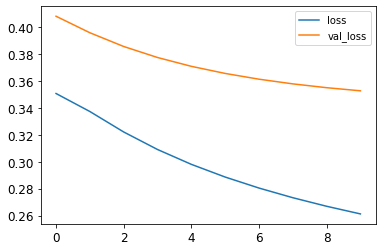

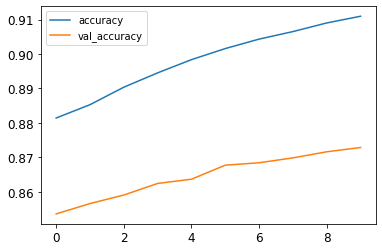

In [12]:
# Results visualization
# Loss and validation loss variation 

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

In [13]:
#Save the previous trained model

modelSaving = xception_model.save_weights('./xceptionmodel', save_format='h5')

In [14]:
#test sample evaluation

score = xception_model.evaluate(test_ds)
print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

88/88 [==============================] - 3s 30ms/step - loss: 0.3263 - accuracy: 0.8835
Test loss:  0.3263016939163208
Test accuracy:  0.8835227489471436


## Guided Backpropagation implementation

In [15]:
def prep_input(path):
    image = tf.image.decode_png(tf.io.read_file(path))
    image = tf.expand_dims(image, axis=0)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [124,124])
    return image

def norm_flat_image(img):
    grads_norm = img[:,:,0]+ img[:,:,1]+ img[:,:,2]
    grads_norm = (grads_norm - tf.reduce_min(grads_norm))/ (tf.reduce_max(grads_norm)- tf.reduce_min(grads_norm))
    return grads_norm

def get_image():
    # Wikipedia lion image https://en.wikipedia.org/wiki/Lion#/media/File:Lion_waiting_in_Namibia.jpg
    # License: CC BY 2.0 https://creativecommons.org/licenses/by/2.0/deed.en
    import urllib.request
    filename = 'monkeypox.jpg'
    img_url = r"https://portaldrauziovarella.nyc3.digitaloceanspaces.com/wp-content/uploads/2022/07/25141417/Depositphotos_481360378_L-1-2.jpg"
    urllib.request.urlretrieve(img_url, filename)

def plot_maps(img1, img2,vmin=0.3,vmax=0.7, mix_val=2):
    f = plt.figure(figsize=(45,15))
    plt.subplot(1,3,1)
    plt.imshow(img1,vmin=vmin, vmax=vmax, cmap="gray")
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.imshow(img2, cmap = "gray")
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(img1*mix_val+img2/mix_val, cmap = "gray" )
    plt.axis("off")
    plt.show()

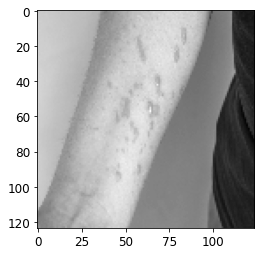

In [16]:
get_image()
img_path = "monkeypox.jpg"
input_img = prep_input(img_path)
input_img = tf.keras.applications.xception.preprocess_input(input_img)
plt.imshow(norm_flat_image(input_img[0]), cmap = "gray")

In [17]:
xception_model(input_img)

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[1.2837787e-01, 1.0429442e-02, 1.4425676e-06, 3.3940503e-04,
        1.9350642e-03, 8.5891676e-01]], dtype=float32)>

In [18]:
xception_model.predict(input_img)

array([[1.2837794e-01, 1.0429392e-02, 1.4425661e-06, 3.3940567e-04,
        1.9350589e-03, 8.5891676e-01]], dtype=float32)

In [19]:
result = xception_model.predict(input_img)
max_idx = result.argmax(axis=1)[0]
max_idx

5

In [20]:
input_img.shape

TensorShape([1, 124, 124, 3])

In [21]:
@tf.custom_gradient
def guidedRelu(x):
    def grad(dy):
        return tf.cast(dy>0,tf.float32)  * tf.cast(x>0,tf.float32) * dy
    return tf.nn.relu(x), grad

In [22]:
layer_dict = [layer for layer in xception_model.layers[1:] if hasattr(layer,'activation')]
for layer in layer_dict:
    if layer.activation == tf.keras.activations.relu:
        layer.activation = guidedRelu
        print("changed")

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed


In [23]:
with tf.GradientTape() as tape:
    tape.watch(input_img)
    result = xception_model(input_img)
    max_score = result[0,max_idx]
grads = tape.gradient(max_score, input_img)

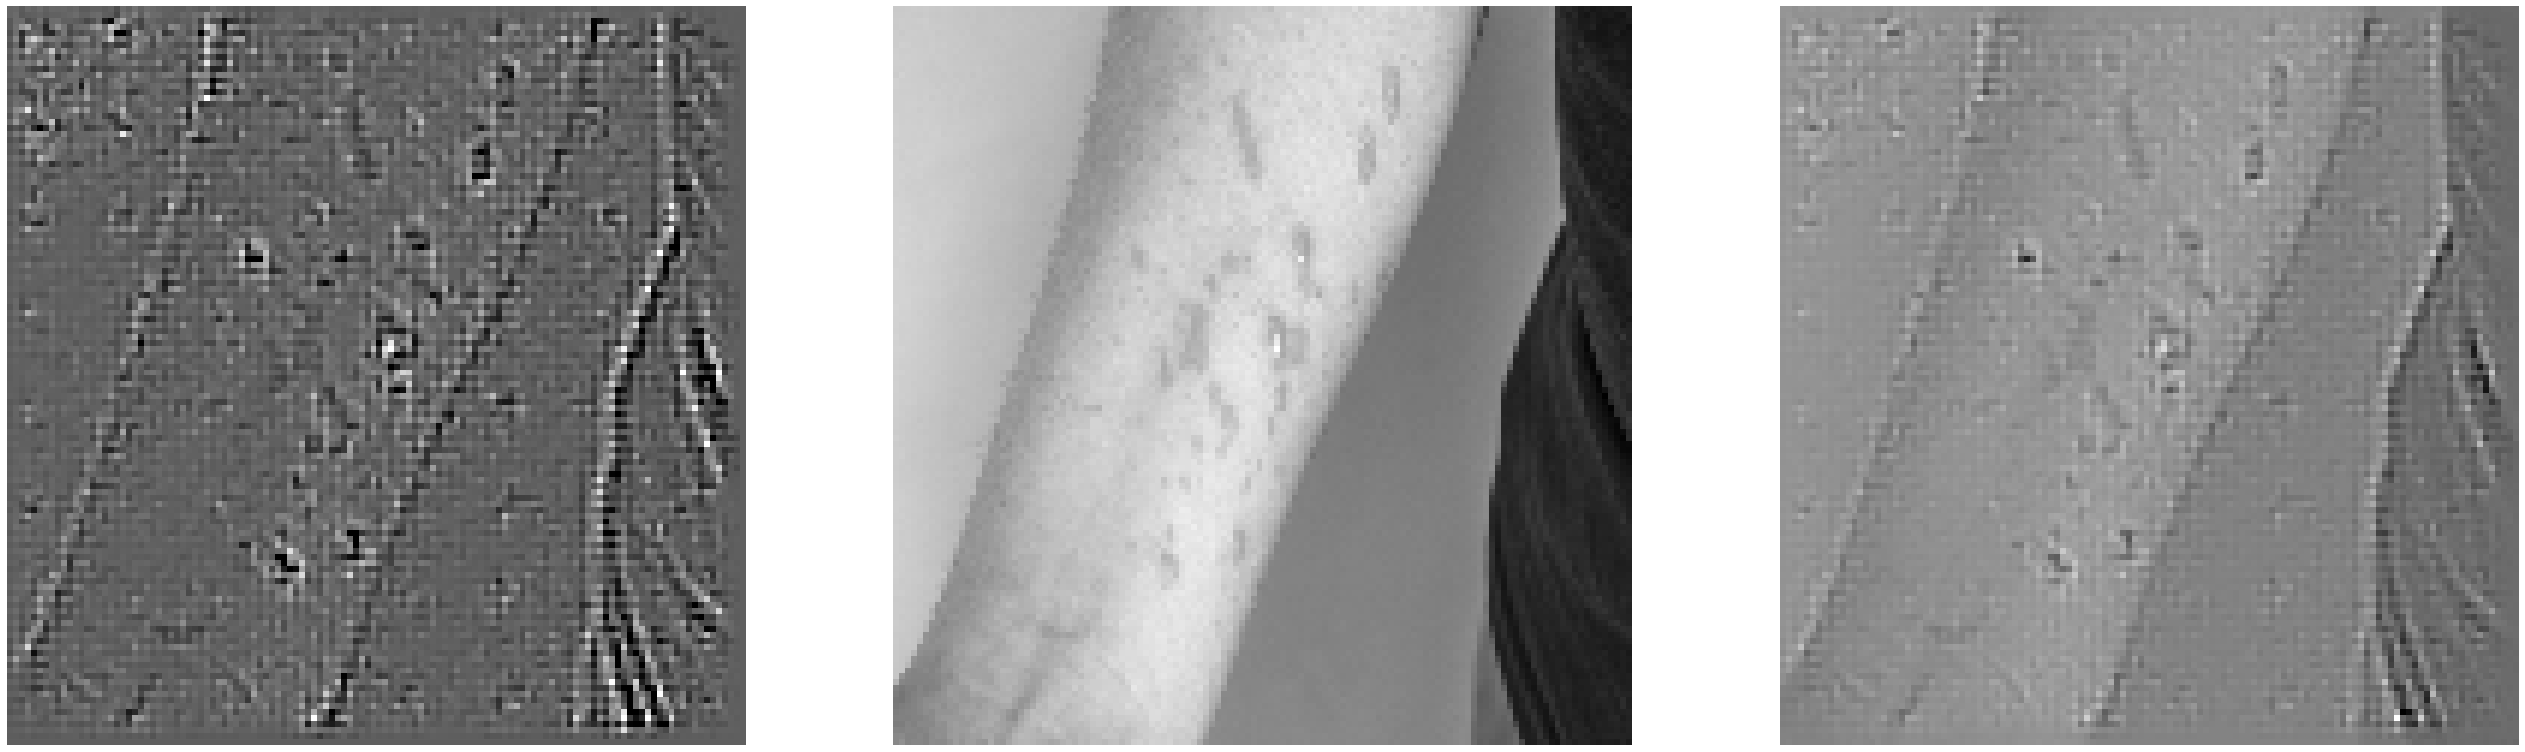

In [24]:
plot_maps(norm_flat_image(grads[0]), norm_flat_image(input_img[0]))